[![CyVers](https://i.imgur.com/yyhmZET.png)](https://www.cyvers.ai/)

# BlockChain Attack Data Set - Exploratory Data Analysis (EDA)

> Notebook by:
> - Royi Avital Royi@cyvers.ai

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 0.1.000 | 30/06/2022 | Royi Avital | First version                                                      |
| 0.2.000 | 25/07/2022 | Royi Avital | Added model selection and visualization of features                |
| 0.3.000 | 31/07/2022 | Royi Avital | Added a view of feature importance (Should be moved to a funciton) |
|         |            |             |                                                                    |

In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version



import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, train_test_split

# Ensemble Engines
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = 'DataSet0'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42

lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]#lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Amount [USD]', 'Receiver Type']
lSlctedFeaturesCalc   = [enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
# lFeaturesRemove       = [FeatureName.TIME_MAX.name, FeatureName.TIME_MIN.name] #<! Auxiliary features to be removed before processing

timeColStr = 'Block Time'

In [6]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

lCsvColName     = ['Transaction ID', 'Block Time', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash', 'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used', 'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level']
lCsvColNameFlag = [True,              True,         True,               True,        True,          True,            True,     True,       True,            True,            True,           True,        True,        True,       True,            True,         True,          False,   False]  #<! Flags if a column is a must to have

# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
#dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '')
dfData, dAssetFile =  LoadCsvFilesDf(lCsvFile, baseFoldePath = '', lColName = lCsvColName, lColFlag =  lCsvColNameFlag, addFileNameCol = True)

numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 350
The number of rows (Samples): 1880307, The number of columns: 20, number of unique sender id's: (350,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level',
       'File Name'],
      dtype='object') with 20 columns


In [7]:
# Convert time data into Pandas format
dfData[timeColStr] = pd.to_datetime(dfData[timeColStr], infer_datetime_format = 'True') #<! Stable time format

In [8]:
# Sort data by transaction date
dfData.sort_values(timeColStr, inplace = True)
# dfData.reset_index(drop = True, inplace = True)

In [9]:
# Meet the data
dfData.head(20)

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level,File Name
905528,0x2971c7bcbf18c57a2879b07a0f6dbbc14b7c928a0335...,NaN,2016-02-12 11:01:25+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,Wallet,0.500000,ETH,0x0000000000000000000000000000000000000000,NaN,2.737825,5.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905527,0xc18b50d6311d2de6f6bfd450a38291297eb0e1c96320...,NaN,2016-05-11 09:23:12+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,Token,50.000000,ETH,0x0000000000000000000000000000000000000000,NaN,499.065146,3.221000e-08,174091.0,74091,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905526,0x29d0b83aeead81925d6df3a5c252bb759811fbc5bb5d...,NaN,2016-05-13 11:44:02+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,26.000000,ETH,0x0000000000000000000000000000000000000000,NaN,275.227201,3.221000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905525,0x292d05383a2d9150c5b24718ceef760608561469222f...,NaN,2016-05-19 07:50:40+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,50.000000,ETH,0x0000000000000000000000000000000000000000,NaN,735.916238,2.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905524,0x4020de95411dd43e8613588f07a8e9643093c8e9c9a2...,NaN,2016-05-20 12:29:30+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,100.000000,ETH,0x0000000000000000000000000000000000000000,NaN,1369.368343,2.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905523,0xde1fb69bc6f78d32413ef8cc800ee4379855636c8daa...,NaN,2016-07-20 13:30:33+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0xbf4ed7b27f1d666546e30d74d50d173d20bca754,Smart Contract,5000.000000,DAO,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,ERC20,NaN,2.000000e-08,158971.0,43971,NaN,NaN,NaN,0,NaN,Furucombo006.csv
509135,0xf8e45e7a318827cd54a415005b30fc67dc4c62e0bb42...,NaN,2016-08-03 10:46:16+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,1.000000,ETH,0x0000000000000000000000000000000000000000,NaN,10.221748,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
509134,0x056b34ec266003515e00f5c4dba9e07be9acf52a2e39...,NaN,2016-08-03 11:03:28+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,1.000000,ETH,0x0000000000000000000000000000000000000000,NaN,10.221748,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
509133,0x25f0d4e11d6eb9929b9ddc85a6a2485b93337d65640e...,NaN,2016-08-03 11:37:25+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,5.000000,ETH,0x0000000000000000000000000000000000000000,NaN,51.108739,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
509132,0x6008875514e32a1fc5152aac6deed0482ff5527aab3d...,NaN,2016-08-03 11:48:55+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,27.000000,ETH,0x0000000000000000000000000000000000000000,NaN,275.987191,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv


# Information about the Data Before Pre Processing

1. See the labeled cases.
2. Count the Labels data.
3. Number of unique assets.
4. Pandas' `info()` and `describe()`.

After this phase, the data is _read only_.

In [10]:
# Look at attack cases
dfData.loc[dfData['Label'] == 1, :]

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level,File Name
508808,0x477df43e6e4b318c8ffed00899a4d7f019c074a89882...,NaN,2017-06-11 12:49:35+00:00,0x1fb15d830ec3cecc9ceb52caff30ad9cb7edb75a,0x0c9d1b3ca852c67bbeabeeb51e9482a845d56868,NaN,6.100000e+01,ETH,0x0000000000000000000000000000000000000000,NaN,2.080586e+04,2.100000e-08,200000.0,21000,NaN,NaN,NaN,1,NaN,FAKEFundYourselfNow001.csv
509088,0x5aa40ba7c64177844bf740d6b5e77f6b39f546ce3314...,NaN,2017-06-11 13:08:20+00:00,0x5503ff6d5f128f482c9a01d4a7911e87be66fbf4,0x0c9d1b3ca852c67bbeabeeb51e9482a845d56868,NaN,2.000000e+01,ETH,0x0000000000000000000000000000000000000000,NaN,6.821593e+03,2.100000e-08,250000.0,21000,NaN,NaN,NaN,1,NaN,FAKEFundYourselfNow003.csv
509079,0x3acef6e3abf653b478be9774df4cca24109e9068d41f...,NaN,2017-06-11 17:30:19+00:00,0x27b206e22560a0d3c3b9122b102e85f178f5baa0,0x0c9d1b3ca852c67bbeabeeb51e9482a845d56868,NaN,2.890000e+01,ETH,0x0000000000000000000000000000000000000000,NaN,9.857202e+03,2.500000e-08,150000.0,21000,NaN,NaN,NaN,1,NaN,FAKEFundYourselfNow002.csv
1790881,0x0e0d16475d2ac6a4802437a35a21776e5c9b681a77fe...,NaN,2017-07-18 22:33:23+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,2.679300e+04,ETH,0x0000000000000000000000000000000000000000,NaN,6.122288e+06,2.100000e-08,162754.0,60001,NaN,NaN,NaN,1,NaN,Multisig002.csv
1790853,0x97f7662322d56e1c54bd1bab39bccf98bc736fcb9c7e...,NaN,2017-07-19 12:14:18+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,4.405500e+04,ETH,0x0000000000000000000000000000000000000000,NaN,8.792960e+06,2.100000e-08,88926.0,58433,NaN,NaN,NaN,1,NaN,Multisig001.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880267,0x9d349d3742ad50a41a3c3769d6319eebfd8b82c8b0d7...,NaN,2022-09-20 05:46:59+00:00,0x00000000ae347930bd1e7b0f35588b92280f9e75,0x0248f752802b2cfb4373cc0c3bc3964429385c26,NaN,1.031957e+03,AXS,0xbb0e17ef65f82ab018d8edd776e8dd940327b28b,erc20,1.273555e+04,7.920000e-09,800000.0,71657,NaN,NaN,NaN,1,NaN,Wintermute001.csv
1880268,0x8b9f4d4a86902eb1e4895729cf776371e15e873916ff...,NaN,2022-09-20 05:46:59+00:00,0x00000000ae347930bd1e7b0f35588b92280f9e75,0x0248f752802b2cfb4373cc0c3bc3964429385c26,NaN,1.711301e+06,XYO,0x55296f69f40ea6d20e478533c15a6b08b654e758,erc20,1.241590e+04,7.920000e-09,800000.0,73800,NaN,NaN,NaN,1,NaN,Wintermute001.csv
1880269,0x948fb49fd7783e78bc8577e627b2724cdff3afd7c545...,NaN,2022-09-20 05:46:59+00:00,0x00000000ae347930bd1e7b0f35588b92280f9e75,0x0248f752802b2cfb4373cc0c3bc3964429385c26,NaN,1.952864e+03,BADGER,0x3472a5a71965499acd81997a54bba8d852c6e53d,erc20,7.695467e+03,7.920000e-09,800000.0,150392,NaN,NaN,NaN,1,NaN,Wintermute001.csv
1880270,0xefd8948379b2295184f465beb4a03d59388235e006b7...,NaN,2022-09-20 05:46:59+00:00,0x00000000ae347930bd1e7b0f35588b92280f9e75,0x0248f752802b2cfb4373cc0c3bc3964429385c26,NaN,1.210097e+06,SPELL,0x090185f2135308bad17527004364ebcc2d37e5f6,erc20,1.316080e+03,7.920000e-09,800000.0,69087,NaN,NaN,NaN,1,NaN,Wintermute001.csv


In [11]:
# Balance of labels: Highly imbalanced data (As expected)
dfData['Label'].value_counts()

0    1876490
1       3817
Name: Label, dtype: int64

In [12]:
# How many unique `Sender ID` (Assets) we have.
# It should match the number of files, if not, it either means we have duplications or teh same asset was attacked twice.
len(dfData['Sender ID'].unique())

350

In [13]:
dfData['Label'].value_counts()

0    1876490
1       3817
Name: Label, dtype: int64

In [14]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1880307 entries, 905528 to 1817649
Data columns (total 20 columns):
 #   Column            Dtype              
---  ------            -----              
 0   Transaction ID    object             
 1   Transaction Time  float64            
 2   Block Time        datetime64[ns, UTC]
 3   Sender ID         object             
 4   Receiver ID       object             
 5   Receiver Type     object             
 6   Amount            float64            
 7   Currency          object             
 8   Currency Hash     object             
 9   Currency Type     object             
 10  Amount [USD]      float64            
 11  Gas Price         float64            
 12  Gas Limit         float64            
 13  Gas Used          int64              
 14  Gas Predicted     float64            
 15  Balance In        float64            
 16  Balance Out       float64            
 17  Label             int64              
 18  Risk Level       

In [15]:
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
count,0.0,1.880307e+06,1.739233e+06,1.880307e+06,1.880307e+06,1.880307e+06,0.0,0.0,0.0,1.880307e+06,0.0
mean,NaN,1.282769e+71,5.636208e+04,7.481671e-08,4.684135e+05,1.971794e+05,NaN,NaN,NaN,2.029988e-03,NaN
std,NaN,1.064165e+74,1.519401e+06,1.113929e-07,1.101270e+06,4.318618e+05,NaN,NaN,NaN,4.500964e-02,NaN
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+04,1.920000e+04,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,4.000000e-01,1.552527e+02,2.500000e-08,1.000000e+05,3.100500e+04,NaN,NaN,NaN,0.000000e+00,NaN
50%,NaN,1.000000e+01,1.150664e+03,5.120000e-08,2.022520e+05,1.000510e+05,NaN,NaN,NaN,0.000000e+00,NaN
75%,NaN,2.304000e+03,7.512707e+03,9.510000e-08,4.100000e+05,2.322180e+05,NaN,NaN,NaN,0.000000e+00,NaN
max,NaN,1.160000e+77,6.141830e+08,2.192162e-05,3.005662e+07,2.577378e+07,NaN,NaN,NaN,1.000000e+00,NaN


# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [16]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 164277


In [17]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [18]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 0


In [19]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [20]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 1716030, The number of columns: 20


# Meet the Data

Basic infomration about the data.

In [21]:
# Basic Data Information
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1716030 entries, 905528 to 1817649
Data columns (total 20 columns):
 #   Column            Dtype              
---  ------            -----              
 0   Transaction ID    object             
 1   Transaction Time  float64            
 2   Block Time        datetime64[ns, UTC]
 3   Sender ID         object             
 4   Receiver ID       object             
 5   Receiver Type     object             
 6   Amount            float64            
 7   Currency          object             
 8   Currency Hash     object             
 9   Currency Type     object             
 10  Amount [USD]      float64            
 11  Gas Price         float64            
 12  Gas Limit         float64            
 13  Gas Used          int64              
 14  Gas Predicted     float64            
 15  Balance In        float64            
 16  Balance Out       float64            
 17  Label             int64              
 18  Risk Level       

In [22]:
# Numeric Data Description
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
count,0.0,1.716030e+06,1.716030e+06,1.716030e+06,1.716030e+06,1.716030e+06,0.0,0.0,0.0,1.716030e+06,0.0
mean,NaN,2.272688e+21,5.712417e+04,7.543262e-08,3.663192e+05,1.878086e+05,NaN,NaN,NaN,2.089124e-03,NaN
std,NaN,2.105169e+24,1.529624e+06,1.131793e-07,6.468623e+05,3.875561e+05,NaN,NaN,NaN,4.565918e-02,NaN
min,NaN,0.000000e+00,2.330000e-47,0.000000e+00,2.100000e+04,1.920000e+04,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,3.298747e-01,1.740211e+02,2.500000e-08,1.000000e+05,2.108000e+04,NaN,NaN,NaN,0.000000e+00,NaN
50%,NaN,5.525130e+00,1.206018e+03,5.200000e-08,2.022220e+05,9.878300e+04,NaN,NaN,NaN,0.000000e+00,NaN
75%,NaN,1.730000e+03,7.739070e+03,9.610000e-08,4.100000e+05,2.287850e+05,NaN,NaN,NaN,0.000000e+00,NaN
max,NaN,1.950000e+27,6.141830e+08,2.192162e-05,3.005662e+07,2.577378e+07,NaN,NaN,NaN,1.000000e+00,NaN


In [23]:
# How many times each hacker attacked
dsAttacksAsset = dfData[dfData['Label'] == 1]['Receiver ID'].value_counts()

print(f'There are {dsAttacksAsset.shape[0]} Attackers')
print(dsAttacksAsset.head(len(dsAttacksAsset))) #<! Last ones should be 1

There are 169 Attackers
0xeda5066780de29d00dfb54581a707ef6f52d8113    416
0xa14d5da3c6bf2d9304fe6d4bc6942395b4de048b    297
0xeb31973e0febf3e3d7058234a5ebbae1ab4b8c23    292
0x83a2eb63b6cc296529468afa85dbde4a469d8b37    189
0xb1af124c860f819bf8de7d4c459e5b31fecdb95e    142
                                             ... 
0x86766247ba3405c5f15f06b895294200809e9cfb      1
0xebc6bd6ac2c9ad4adf4ba57e9f709b8b9cf03c40      1
0x601a1dd67a637fc3ff0141724152e15abe1905f7      1
0xad6a4ace6dcc21c93ca9dbc8a21c7d3a726c1fb1      1
0xee14140f20fb737809ca206c238382b3f802ca6c      1
Name: Receiver ID, Length: 169, dtype: int64


Text(0, 0.5, 'Number of Attackers')

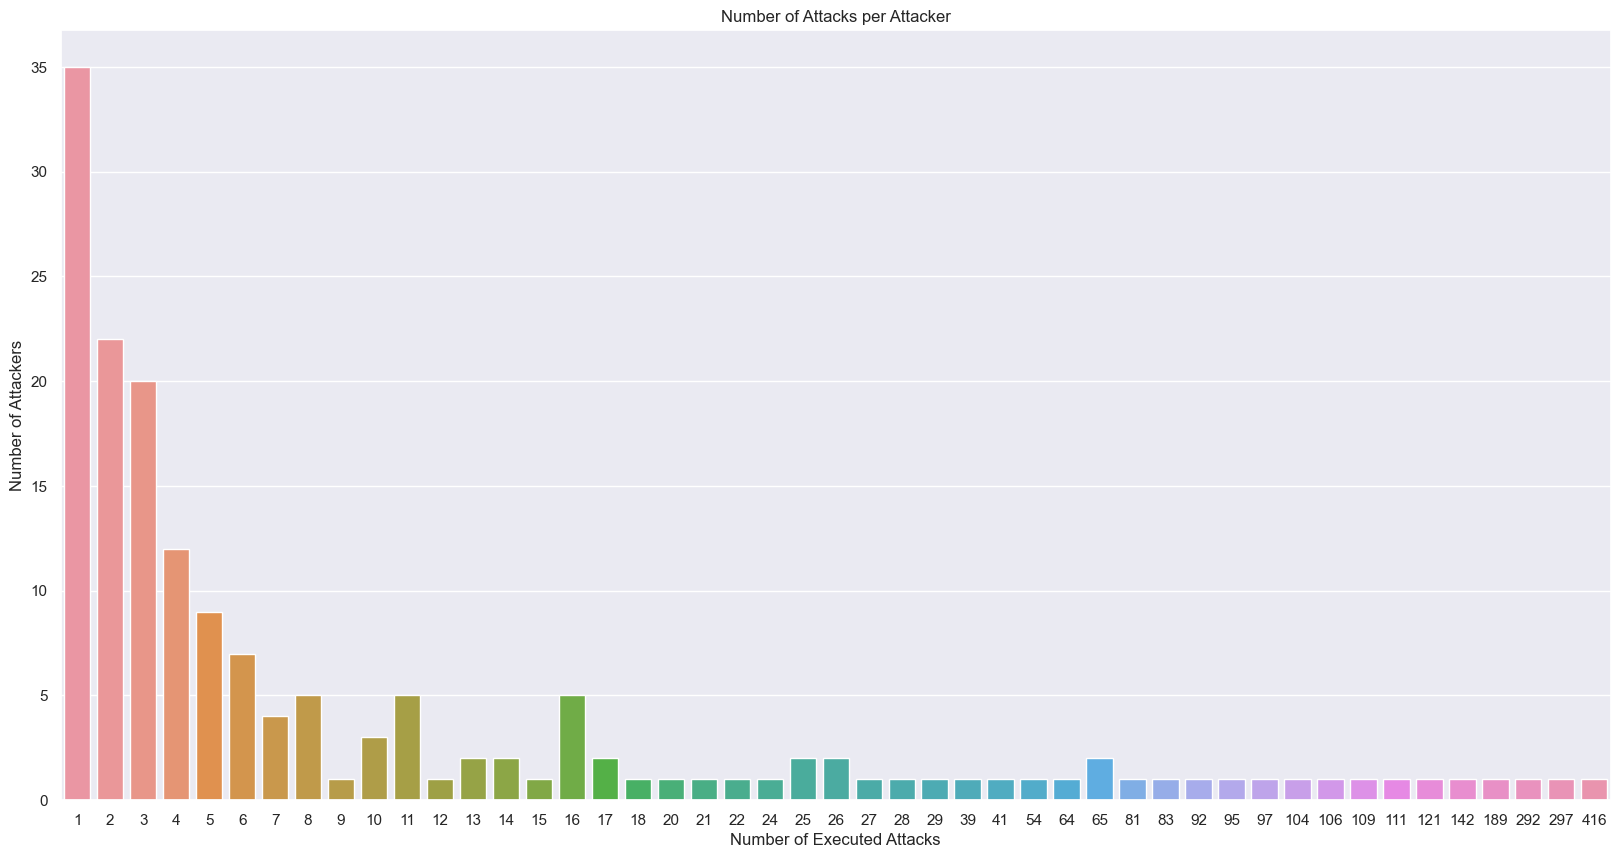

In [24]:
hF, hA = plt.subplots(figsize = (20, 10)) # 
sns.countplot(dsAttacksAsset, ax = hA)
hA.set_title('Number of Attacks per Attacker')
hA.set_xlabel('Number of Executed Attacks')
hA.set_ylabel('Number of Attackers')

In [25]:
# How many times each asset was attacked?
dsSenderCount = dfData[dfData['Label'] == 1]['Sender ID'].value_counts()

Text(0, 0.5, 'Number of Assets')

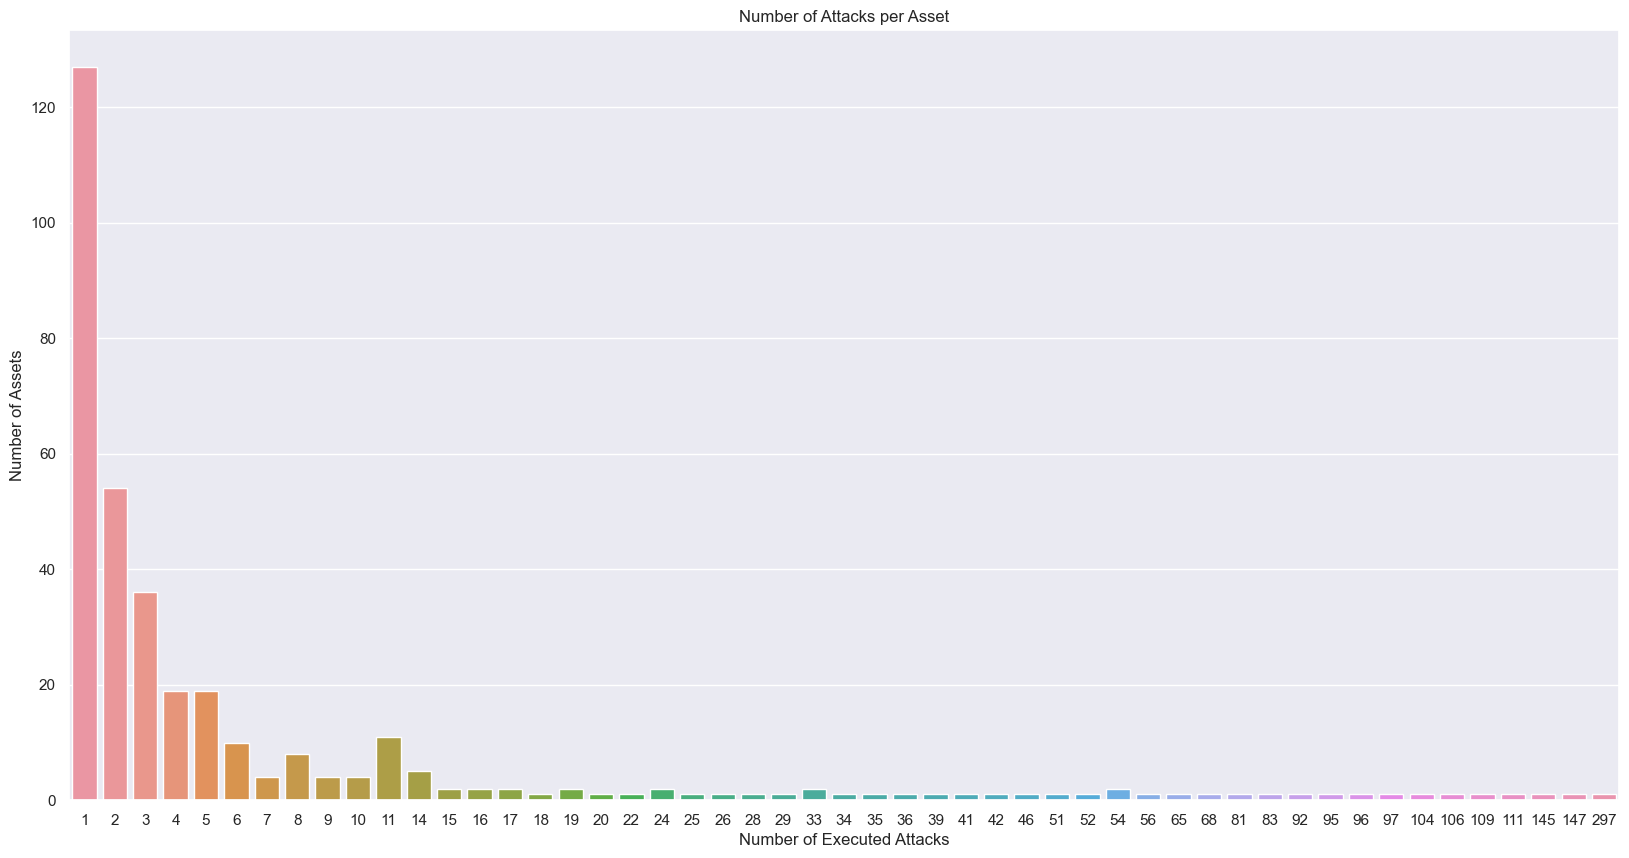

In [26]:
hF, hA = plt.subplots(figsize = (20, 10)) # TODO: Display an histogram (How many assets were attacked 1, 2, ...)
sns.countplot(dsSenderCount, ax = hA)
hA.set_title('Number of Attacks per Asset')
hA.set_xlabel('Number of Executed Attacks')
hA.set_ylabel('Number of Assets')

In [27]:
# How many different assets each attacker attacked? How many times per asset?
dsAttacksIdAttacker = dfData[dfData['Label'] == 1].groupby(['Receiver ID', 'Sender ID'])['Transaction ID'].count().reset_index(name = 'Number of Attacks')  
dsAttacksIdAttacker.head(40)

,Receiver ID,Sender ID,Number of Attacks
0,0x0000000a5aab7e0b99e8b30028d790de05da0f09,0xb314fd4ac6e10a7e27929cbc8db96743739c82b6,28
1,0x0217f93565ede01fa65450281631a67808d2eedc,0x37d387c2b7e5fb493091f01c164be5332811d11e,95
2,0x0248f752802b2cfb4373cc0c3bc3964429385c26,0x00000000ae347930bd1e7b0f35588b92280f9e75,109
3,0x0333e323e61aa8afa38a1623604a165dcb9f4fec,0xe30dc9b3c29534e9b4e9a166c2f44411163ad59f,4
4,0x03d1d0e4061152c6a698309aaa4968aae58585a8,0x2f2ca827b3c2c57d554d08698e10c3d8016e9f81,1
5,0x05605a807f4444f8c2fdbc44f51717ab6c055cd2,0x6fb209016b489977ecc78abf3eb5a8613e7ac728,4
6,0x079667f4f7a0b440ad35ebd780efd216751f0758,0x5dbcf33d8c2e976c6b560249878e6f1491bca25c,1
7,0x07ba7e8947f8fb4d33f3c7e25c2cb35b858f02eb,0x8484ef722627bf18ca5ae6bcf031c23e6e922b30,1
8,0x07e02088d68229300ae503395c6536f09179dc3e,0xc5ac25cfc2b8284e84ca47dad21cf1319f732c11,3
9,0x098b716b8aaf21512996dc57eb0615e2383e2f96,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,3


In [28]:
# Initialize the Pandas Extension (Don't change the Index from now on!)
numGrps = dfData.GrpBySender.numGrps

### SASA vs. SAMA Cases

Definitions:

 * SASA:
 * SAMA:

**Remark**: Move to:

SASASW - Single Asset, Single   Attacks, Single   Wallets  
SAMASW - Single Asset, Multiple Attacks, Single   Wallets (SAMA)  
SAMAMW - Single Asset, Multiple Attacks, Multiple Wallets (SAMA)  

In [29]:
# Analysis of Attack Type
# !!! The function `CalcAttackType()` uses the Pandas extension, hence it should be initialized before!
dsAttackType, dfAttackType = CalcAttackType(dfData)

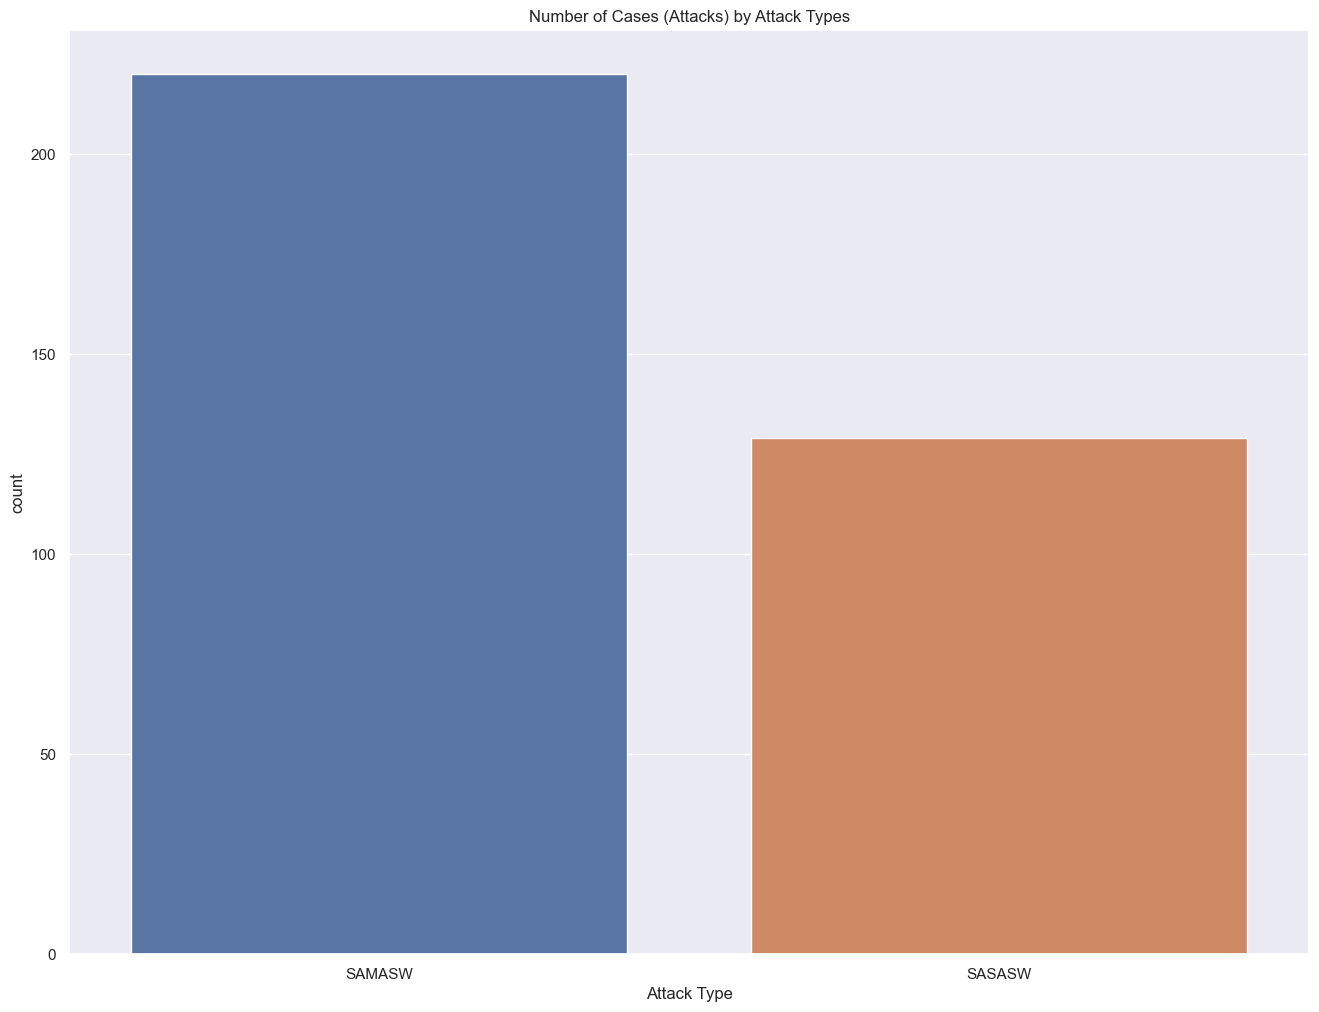

In [30]:
# Display an Histogram of the Attack Types
hF, hA = plt.subplots(figsize = (16, 12))
sns.countplot(x = dfAttackType['Attack Type'], ax = hA)
hA.set_title('Number of Cases (Attacks) by Attack Types')
plt.show()

## Feature Engineering

This section adds features and engineers them.  
Most features work on the `Sender ID` group.

#### Amount Based Features:

1. The STD of the user vs the average STD of all other users of the asset.
2. The Median of the user vs the average STD of all other users of the asset.
3. 

#### Date Based Features

1. The day of the week.
2. Weekend.
3. Hour of the day.
4. STD fo the time difference of the user vs. the avergae of all other users.
5. Median fo the time difference of the user vs. the avergae of all other users.

**Remark**: For wallets with a lot of activity we need to analyze the "activity hours" and profile it.


The features are:

 1. Day of the Week.

Remarks:

 *  Features x-y are time / frequency related.
 *  Features z-t are trasnaction realted.


In [31]:
# Pre Process

dfGbs = dfData.GrpBySender

### Features per Asset

In [32]:
# Features - Amount Based

sum_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MAX)
coint_c         = dfGbs.AggBySender(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggBySender(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE)

gas_pr_mean     = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_pr_std      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_pr_med      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)


dfData[FeatureName.AMOUNT_SUM_ASSET.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_ASSET.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_ASSET.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_ASSET.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_ASSET.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_ASSET.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_ASSET.name]          = max_s
dfData[FeatureName.TSX_COUNT_ASSET.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_ASSET.name]     = coint_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_ASSET.name] = receiver_type_c

dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_ASSET.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_ASSET.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_ASSET.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_ASSET.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_ASSET.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_ASSET.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_ASSET.name] = gas_used_med

#COIN_TYPE_COUNT_USR                 

In [33]:
# Features - Time Based

td_mean_s   = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_ASSET.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_ASSET.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_ASSET.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_ASSET.name]    = td_max_s

### Features per User

In [34]:
# Features - Amount Based (User)

sum_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
coin_c          = dfGbs.AggByReceiver(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggByReceiver(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE) #<! Royi: We need to check why is it so important?!?!

gas_pr_mean     = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)

gas_pr_std      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)

gas_pr_med      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)

gas_pr_quant    = dfGbs.dfSubGrpByRec[dfGbs.gasPriceColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_lim_quant   = dfGbs.dfSubGrpByRec[dfGbs.gasLimitColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_used_quant  = dfGbs.dfSubGrpByRec[dfGbs.gasUsedColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)


dfData[FeatureName.AMOUNT_SUM_USR.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_USR.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_USR.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_USR.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_USR.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_USR.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_USR.name]          = max_s
dfData[FeatureName.TSX_COUNT_USR.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_USR.name]     = coin_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_USR.name] = receiver_type_c    

dfData[FeatureName.GAS_PRICE_MEAN_USR.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_USR.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_USR.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_USR.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_USR.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_USR.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_USR.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_USR.name] = gas_used_med

dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name] = gas_pr_quant
dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name] = gas_lim_quant
dfData[FeatureName.GAS_USED_QUANTILE_USR.name] = gas_used_quant


In [35]:
# Features - Time Based (User)

td_mean_s   = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_USR.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_USR.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_USR.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_USR.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_USR.name]    = td_max_s

### Features based on Transaction Time

In [36]:
# Features - Time Based

dfData[FeatureName.TIME_HOUR.name]    = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.HOUR_DAY)
dfData[FeatureName.TIME_WEEKDAY.name] = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.DAY_WEEK)

### Features based on Ratios

In [37]:
# Ratio Based Features

dfData[FeatureName.AMOUNT_MEAN_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_MEAN_USR.name] / dfData[FeatureName.AMOUNT_MEAN_ASSET.name]
dfData[FeatureName.AMOUNT_STD_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_STD_USR.name] / dfData[FeatureName.AMOUNT_STD_ASSET.name]
dfData[FeatureName.TIME_DIFF_MEAN_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_MEAN_USR.name] / dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]
dfData[FeatureName.TIME_DIFF_STD_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_STD_USR.name] / dfData[FeatureName.TIME_DIFF_STD_ASSET.name]

### Features based on Frequency

In [38]:
# Frequency Based Features

dfData[FeatureName.TIME_MAX.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
dfData[FeatureName.TIME_MIN.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)

dfData[FeatureName.TIME_INTERVL_USR.name] = ((dfData[FeatureName.TIME_MAX.name] - dfData[FeatureName.TIME_MIN.name])).dt.total_seconds()

# Frequency of the User Transactions
dfData[FeatureName.TSX_FREQ_HZ_USR.name] = dfData[FeatureName.TSX_COUNT_USR.name] / dfData[FeatureName.TIME_INTERVL_USR.name]

### Gas ratio features(experimental)

In [39]:
#Ratios between the user to the mean of all users.
dfData[FeatureName.GAS_PRICE_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name]
dfData[FeatureName.GAS_LIMIT_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name]
dfData[FeatureName.GAS_USED_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_ASSET.name] 
#Gas Price', 'Gas Limit', 'Gas Used'
dfData[FeatureName.GAS_PRICE_LIMIT_RATIO.name] = dfData['Gas Price'] / dfData['Gas Limit']
dfData[FeatureName.GAS_PRICE_USED_RATIO.name] = dfData['Gas Price'] / dfData['Gas Used']
dfData[FeatureName.GAS_USED_LIMIT_RATIO.name] = dfData['Gas Used'] / dfData['Gas Limit'] 

dfData[FeatureName.GAS_PRICE_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_USR.name]
dfData[FeatureName.GAS_PRICE_USED_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_USR.name]
dfData[FeatureName.GAS_USED_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_USR.name] 


#Compare it to 75 quantile (TSX Gas Price / Quantile(75) of Gas Price).
dfData[FeatureName.GAS_PRICE_QUANTILE_RATIO.name] = dfData['Gas Price'] / dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name]
dfData[FeatureName.GAS_LIMIT_QUANTILE_RATIO.name] = dfData['Gas Limit'] / dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name]
dfData[FeatureName.GAS_USED_QUANTILE_RATIO.name] =  dfData['Gas Used'] / dfData[FeatureName.GAS_USED_QUANTILE_USR.name]

In [40]:
#Feature to indicate first transaction
dfData[FeatureName.MIN_INDICATOR.name] = 0 ; dfData.loc[dfData[timeColStr] == dfData[FeatureName.TIME_MIN.name], FeatureName.MIN_INDICATOR.name] = 1 
### TODO !!! this can be invorrect. it will need a review !!!!!! 

In [41]:
#56
#Create features based on the currency of the transactions:
# 1. The number of different types of currencies per user. <-- done previously = dfData[FeatureName.COIN_TYPE_COUNT_USR.name]
# 2. The average of the number of types of all user for an asset. <-- groupby asset , mean(number of different types of currencies per user)
# 3. The ratio between a specific user to the average of the asset. --> 1/2
    

dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]    = dfGbs.AvgByUserCoinType()
dfData[FeatureName.COIN_TYPE_USR_MEAN_ASSET_RATIO.name]  = dfData[FeatureName.COIN_TYPE_COUNT_USR.name] / dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]


In [66]:
#dfData['File Name'].unique().shape
#dfData[dfData['Label'] == 1]['Amount [USD]'].sum()
#dfData['Transaction ID'].count()
dfData[dfData['Label'] == 1]['Transaction ID'].count() , dfData[dfData['Label'] == 0]['Transaction ID'].count()

(3585, 1712445)

In [68]:
#dfData[dfData['Label'] == 1]['Sender ID']
vals = dfData[dfData['Label'] == 1].groupby(['File Name'])['Sender ID'].count().to_dict()
mults = [k for k in vals if vals[k]>1]
sing =  [k for k in vals if vals[k] == 1 ]

In [73]:
dfData[(dfData['Label'] == 1) & (dfData['File Name'].isin(sing))]['Amount [USD]'].sum()

379751973.68591136

In [63]:
len(vals) , len(mults) , len(sing)
220/347 , 127/347 , 0.6340057636887608 + 0.3659942363112392

(0.6340057636887608, 0.3659942363112392, 1.0)

In [ ]:
'''
Total number of cases
total amount of hacks USD
Total number of transactions
Total number of labeled 1 transactions
Total number of labeled 0 transactions
% cases of multiple transactions attacks
% cases of single transaction attack
mean, median time between 1st and last transaciton (multiple transactions attacks)
Total amount USD of single transactions attacks
Total amount USD of multiple transactions attacks



Total number of cases = 350
total amount of hacks USD = 3563876455.111165
Total number of transactions = 1716030
Total number of labeled 1 transactions = 3585 
Total number of labeled 0 transactions = 1712445
% cases of multiple transactions attacks = 0.6340057636887608
% cases of single transaction attack = 0.3659942363112392
mean, median time between 1st and last transaciton (multiple transactions attacks)  <<--- not done yet
Total amount USD of single transactions attacks = 3184124481.4252543
Total amount USD of multiple transactions  = 379751973.68591136

'''

In [67]:
(3585 + 1712445)

1716030

## Features Visualization

In [ ]:
numFeatures     = len(lSlctdFeatures)

In [ ]:
# Display the Scatter of the Features

oDropdwon = Dropdown(
    options     = lSlctdFeatures,
    value       = 'Amount [USD]',
    description = 'Select Feature:',
    style       = {'description_width' : 'initial'}
)

interact(lambda yColName: DisplayScatterFeature(dfData, 'Label', yColName, 'Suspicious'), yColName = oDropdwon)

In [ ]:
dfData['File Name']

In [ ]:
def DisplayKdeFeature_(dfData, colName, labelName, legendTitle, hA = None ) -> None:
    
    if hA is None:
        hF, hA = plt.subplots(figsize = (20, 10))
    
    sns.kdeplot(dfData[dfData[labelName] == 0][colName], ax = hA, color = 'b', label = '0')
    sns.kdeplot(dfData[dfData[labelName] == 1][colName], ax = hA, color = 'r', label = '1')

    hA.legend(title = legendTitle)
    plt.show()


In [ ]:
# Display the Density of the Features

oDropdwon = Dropdown(
    options     = lSlctdFeatures,
    value       = 'Amount [USD]',
    description = 'Select Feature:',
    style       = {'description_width' : 'initial'}
)

interact(lambda yColName: DisplayKdeFeature(dfData, yColName, 'Label', 'Suspicious'), yColName = oDropdwon)

## Features Pre Processing (For Training Phase)

In [ ]:
dfData_ = dfData.copy(deep=True) ###<<-- I create a copy of data frame for experiment with categorical variables 

In [ ]:
# Pre Processing Data
dfData.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData.fillna(0, inplace = True)
dfX = dfData[lSlctdFeatures].copy()
for catColName in lCatFeatures:
    dfX[catColName], _ =  pd.factorize(dfX[catColName])

In [ ]:
# Input Data for Classifier

lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]

mX = dfX[lNumericalFeatures].to_numpy()
mC = dfX[lCatFeatures].to_numpy()
vY = dfData['Label'].to_numpy()
# Scaling the data
hStdScaler = StandardScaler() #<! Don't touch categorial data
mX = hStdScaler.fit_transform(mX)
mX = np.concatenate((mX, mC), axis = 1)

### Display the PPS Matrix

The idea is to see the relationship between the features not by a linear correlation but by the ability to predict them.

In [ ]:
# Creating the DF for the PPS analysis
dfTmp = dfData[lSlctdFeatures + ['Label']].copy()

for featureName in (lCatFeatures + ['Label']):
    dfTmp[featureName] = pd.Categorical(dfTmp[featureName])  

In [ ]:
# Feature PPS - Which featuers are important?

# Pay attention, cross validation is K-Fold -> Don't over split the data
mPPS = pps.matrix(dfTmp, **{'cross_validation': numCrossValPps, 'random_seed': randomState})[['x', 'y', 'ppscore']].pivot(columns = 'x', index = 'y', values = 'ppscore') #<! We should set `Label` as a categorial variable

# Visualization of PPS
hF, hA = plt.subplots(figsize = (30, 30))
sns.heatmap(mPPS, annot = True, fmt = '.2f', cmap = plt.get_cmap('coolwarm'), cbar = False, vmin = 0, vmax = 1, ax = hA) 

plt.setp(hA.get_xticklabels(), ha = "center", rotation = 45)
plt.setp(hA.get_yticklabels(), rotation = 'horizontal')
hA.set_title('Predictive Power Score (PPS)')

In [ ]:
# Validation the columns are legit
dfX.columns

## Model Training and Evaluation

### Classic Train Test Split

In [ ]:
mXTrain, mXTest, vYTrain, vYTest = train_test_split(mX, vY, test_size = testSetRatio, random_state = randomState, stratify = vY)

In [ ]:
xgbModel = XGBClassifier(use_label_encoder = False)
xgbModel.fit(mXTrain, vYTrain)
vYPred = xgbModel.predict(mXTest)

In [ ]:
DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)

In [ ]:
dsScoreSumm = GenClassifierSummaryResults(vYTest, vYPred)
dfScoreSummary  = pd.DataFrame(dsScoreSumm, columns = ['Score'])
dfScoreSummary

### K Fold Training

In [ ]:
# Training by Transactions (K-Fold)
hKFoldSplt = StratifiedKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrinIdx, vTestIdx in hKFoldSplt.split(mX, vY):
    mXTrain, mXTest, vYTrain, vYTest = mX[vTrinIdx, :], mX[vTestIdx, :], vY[vTrinIdx], vY[vTestIdx]
    xgbModel = XGBClassifier(use_label_encoder = False)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

In [ ]:
lTotalFeatures = lNumericalFeatures + lCatFeatures
len(lTotalFeatures)

In [ ]:
dfFeatures = pd.DataFrame(data = list(zip(lTotalFeatures, xgbModel.feature_importances_)), columns = ['Feature Name', 'Feature Importance'])

In [ ]:
hF, hA = plt.subplots(figsize = (32, 8))
sns.barplot(data = dfFeatures, x = 'Feature Name', y = 'Feature Importance', ax = hA)
plt.setp(hA.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
# Pre Processing data to match the text indices
vTetsIdxDf = dfData.index[vTestIdx]
dAttackTypeName = {}
for attackTypeEnum in AttackType:
    dAttackTypeName[attackTypeEnum.value] = attackTypeEnum.name


In [ ]:
GenClassifierSummaryResultsGrp(vYTest, vYPred, vGrpLabel = dsAttackType[vTetsIdxDf].to_numpy(), dGrpName = dAttackTypeName) #<! Results don't look reasonable

In [ ]:
# Training by Files (K-Fold)
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX[vTrainIdx, :], mX[vTestIdx, :], vY[vTrainIdx], vY[vTestIdx]
    xgbModel = XGBClassifier(use_label_encoder = False)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

### K-fold training, using categorical variables (EXPERIMENT)

In [ ]:
###### only pd.df approach is working, numpy(dtype=object) didn't work so it is not represented
#make sure below lists are defined
lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]
lTotalFeatures = lNumericalFeatures + lCatFeatures
feature_types_ = ['c' if x in lCatFeatures  else 'float' for x in lTotalFeatures]#feature_types_ = ['c' if x in lCatFeatures  else float for x in lTotalFeatures]

In [ ]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

dfData_.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_.fillna(0, inplace = True)
dfX_ = dfData_[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[lNumericalFeatures] = hStdScaler.fit_transform(dfX_[lNumericalFeatures])


In [ ]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_['Label']


In [ ]:
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

### Data Split

In [ ]:

if trainMode == TRAIN_BY_FILES:
    hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
    gKFoldSplit = hKFoldSplt.split(mX, vY, groups = dfData['Sender ID'])
else:
    hKFoldSplt = StratifiedKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
    gKFoldSplit = hKFoldSplt.split(mX, vY)


### Model Training

In [ ]:
skPipeline = Pipeline([('clf', XGBClassifier())])
dPipelineParams = {'clf': [XGBClassifier(), LGBMClassifier()]}

In [ ]:
gridSearchCv = GridSearchCV(skPipeline, dPipelineParams, scoring = gridSearchScore, cv = hKFoldSplt)

if trainMode == TRAIN_BY_FILES:
    gridSearchCvF = gridSearchCv.fit(mX, vY, groups = dfData['Sender ID'])
else:
    gridSearchCvF = gridSearchCv.fit(mX, vY)


In [ ]:
vYPred = gridSearchCvF.predict(mXTest)
DisplayConfusionMatrix(vYTest, vYPred, lClasses = gridSearchCvF.classes_)
print(GenClassifierSummaryResults(vYTest, vYPred))

### GridSearch and Pipelines combo:


In [ ]:
#skPipeline = Pipeline([('clf', XGBClassifier())])
#dPipelineParams =  {'clf': [XGBClassifier(), LGBMClassifier()]}


skPipeline = Pipeline([("classifier", RandomForestClassifier())])

dPipelineParams = [ {"classifier": [XGBClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20],
                                   "classifier__tree_method" : ["hist", "gpu_hist"]
                    },
                    {"classifier": [LGBMClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20]
                                   #"classifier__class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    },  
                    {"classifier": [RandomForestClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20],
                                   "classifier__class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }                            
                    ]


In [ ]:
##########make sure mX, vY are not redefined into dfs(simply skip K-fold training, using categorical variables (EXPERIMENT) part), naming should be later changed

In [ ]:
gridSearchCv = GridSearchCV(skPipeline, dPipelineParams, scoring = gridSearchScore, cv = hKFoldSplt)

if trainMode == TRAIN_BY_FILES:
    gridSearchCvF = gridSearchCv.fit(mX, vY, groups = dfData['Sender ID'])
else:
    gridSearchCvF = gridSearchCv.fit(mX, vY)


In [ ]:
print(gridSearchCvF.best_estimator_.get_params()["classifier"])

In [ ]:
vYPred = gridSearchCvF.predict(mXTest)
DisplayConfusionMatrix(vYTest, vYPred, lClasses = gridSearchCvF.classes_)
print(GenClassifierSummaryResults(vYTest, vYPred))